In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch.hub
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Loading the Data

data_dir = "hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

for x in ['train', 'val']:
    x_dataloaders = dataloaders[x]
    x_features, x_labels = next(iter(x_dataloaders))
    print(f"{x}_Feature batch shape: {x_features.size()}")
    print(f"{x}_Labels batch shape: {x_labels.size()}")
    img = to_pil_image(x_features[0].squeeze())
    label = x_labels[0]
    #plt.imshow(img)
    #plt.show()
    #print(f"Label: {label}")

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes)
print(class_names)

train_Feature batch shape: torch.Size([4, 3, 299, 299])
train_Labels batch shape: torch.Size([4])
val_Feature batch shape: torch.Size([4, 3, 299, 299])
val_Labels batch shape: torch.Size([4])
{'train': 244, 'val': 153}
['ants', 'bees']


In [5]:
#Creating the model
model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    pretrained=True,)

model = model.to(device)

#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

#Training the model
num_epochs = 10
train_loader = dataloaders['train']
training_losses = []
epochs = range(1, num_epochs + 1)

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs= model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    
    epoch_loss = running_loss / len(train_loader)  # Calculate the average loss for the epoch
    training_losses.append(epoch_loss)  # Append the average loss to the list

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}")


Using cache found in /Users/pratiksakariya/.cache/torch/hub/moskomule_senet.pytorch_master


Epoch 1/10, Training Loss: 1.3160272734087022


In [42]:
#Validation Phase
model.eval()
val_loader = dataloaders['val']

with torch.no_grad():
    validation_losses = []
    epochs = range(1, num_epochs + 1)
    for epoch in range(num_epochs):
        validation_loss = 0.0
        for inputs, labels in val_loader:  # Assuming val_loader is your validation data loader
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
        
        val_epoch_loss = validation_loss / len(val_loader)
        validation_losses.append(val_epoch_loss)
        print(f"Epoch {epoch}/{num_epochs}, Validation Loss: {val_epoch_loss}")


Epoch 0/10, Validation Loss: 0.7799063317286663
Epoch 1/10, Validation Loss: 0.7799041958955618
Epoch 2/10, Validation Loss: 0.7719402339978095
Epoch 3/10, Validation Loss: 0.7869528719247916
Epoch 4/10, Validation Loss: 0.779906805509176
Epoch 5/10, Validation Loss: 0.7831847469011942
Epoch 6/10, Validation Loss: 0.7869519751805526
Epoch 7/10, Validation Loss: 0.7799052519676013
Epoch 8/10, Validation Loss: 0.7788759599893521
Epoch 9/10, Validation Loss: 0.7799062797656426


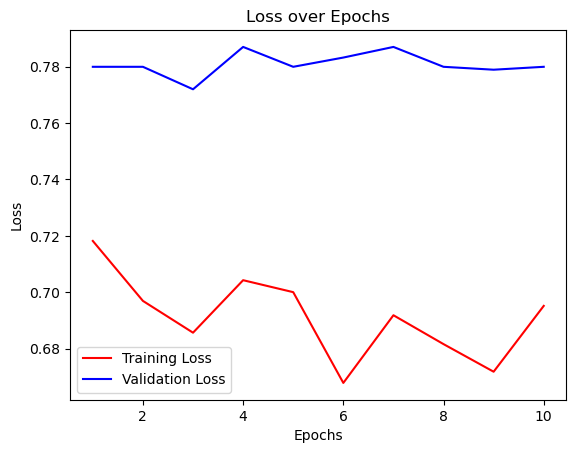

In [43]:
#plot the losses
plt.plot(epochs, training_losses, 'r-', label='Training Loss')  # Red line for training loss
plt.plot(epochs, validation_losses, 'b-', label='Validation Loss')  # Blue line for validation loss

# Adding titles and labels
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()
